In [1]:
import numpy as np
from cgp.graph import Graph
from cgp.population import Population
from automata import CA_2D_model
import test_images
from arg_parser import parse_args

In [2]:
TARGET_EMOJI = 0  # @param "🦎"
MAX_HEIGHT = 15
POPULATION = 4
APPLY_SOBEL_FILTER = False
VISION = 1
TESTS_FOR_EACH_TREE = 1
N_TOTAL_STEPS = 100
GENS = 30
SAVETO = None
RENDER = False
LIMIT = 10000
EXTRA_LAYERS = 3
GEN_CHAMPIONS = 1
FITNESS_GOAL = 0

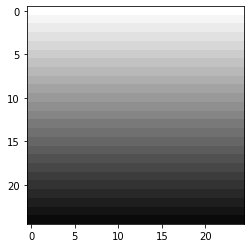

In [3]:
# TARGET_IMG = test_images.load_emoji(0, "data/stick.png", 25)
# TARGET_IMG = test_images.load_emoji(0, "data/brazil.png", 25)
# TARGET_IMG = test_images.column_img()
# TARGET_IMG = test_images.plus_img()
TARGET_IMG = test_images.degrade_img()
# TARGET_IMG = test_images.x_img()
# TARGET_IMG = test_images.diagonal_img()
# TARGET_IMG = test_images.load_emoji(command_line_args.img)
test_images.print_img(TARGET_IMG)

In [4]:
input_size = (VISION+2)**2
if APPLY_SOBEL_FILTER:
    input_size *= 3

In [5]:
addition = lambda x, y: x+y
multiplication = lambda x, y: x*y
subtraction = lambda x, y: x-y
constant = lambda x: x
protected_div = lambda x, y: 1 if y == 0 else x/y
increment = lambda x: x+1
invert = lambda x: -x

seed = 2002
Graph.rng = np.random.RandomState(seed)

Population.add_operation(arity=1, func=lambda x: 1, string="1")
Population.add_operation(arity=1, func=lambda x: .5, string="0.5")
Population.add_operation(arity=1, func=lambda x: .1, string="0.1")
Population.add_operation(arity=1, func=constant, string="x")
Population.add_operation(arity=1, func=increment, string="x+1")
Population.add_operation(arity=1, func=invert, string="-x")
Population.add_operation(arity=2, func=addition, string="x+y")
Population.add_operation(arity=2, func=multiplication, string="x*y")
Population.add_operation(arity=2, func=subtraction, string="x-y")
Population.add_operation(arity=2, func=protected_div, string="*x/y")

In [6]:
def eval_individual(individual: Graph, target_image, layers, render=False):
    shape = target_image.shape
    ca = CA_2D_model(shape[0], shape[1], individual.operate, layers)
    
    total_fitness = 0.0
    for i in range(TESTS_FOR_EACH_TREE):
        ca.reset_ca()

        for _ in range(N_TOTAL_STEPS):
            if render:
                test_images.print_img(ca.remove_pad())
                print(ca.fitness(target_image))
            update = ca.update()
            if not update: # the automata got stable
                break

        total_fitness += ca.fitness(target_image)  

    fitness = (total_fitness / TESTS_FOR_EACH_TREE) 
    return fitness

In [7]:
TARGET_IMG = test_images.degrade_img()
# test_images.print_img(TARGET_IMG)
total_layers = 1 + EXTRA_LAYERS
population = Population(
    population_size=POPULATION,
    n_in=total_layers*input_size,
    n_out=total_layers,
    n_row=8,
    n_col=4,
    levels_back=5,
    mutation_strategy="prob",
    fitness_func=lambda x: eval_individual(x, TARGET_IMG, total_layers),
    minimize_fitness=True,
    point_mut_qnt=10,
    prob_mut_chance=.2,
    mutate_active_only=False
)

In [8]:
population.one_plus_lamda(10, GEN_CHAMPIONS, FITNESS_GOAL, report = True)
# return pop, log, hof

generation  0
0  fit:  52.24999999999994
1  fit:  162.2499999999999
2  fit:  196.00000000000054
3  fit:  196.00000000000054
Best fitness of gen:  52.24999999999994
generation  1
0  fit:  52.24999999999994
4  fit:  196.00000000000054
5  fit:  52.24999999999994
6  fit:  52.24999999999994
7  fit:  52.24999999999994
Best fitness of gen:  52.24999999999994
generation  2
7  fit:  52.24999999999994
8  fit:  196.00000000000054
9  fit:  52.24999999999994
10  fit:  196.25000000000054
11  fit:  1000.0
Best fitness of gen:  52.24999999999994
generation  3
9  fit:  52.24999999999994
12  fit:  196.00000000000054
13  fit:  196.00000000000054
14  fit:  162.2499999999999
15  fit:  52.24999999999994
Best fitness of gen:  52.24999999999994
generation  4
15  fit:  52.24999999999994
16  fit:  52.24999999999994
17  fit:  52.24999999999994
18  fit:  52.24999999999994
19  fit:  196.00000000000054
Best fitness of gen:  52.24999999999994
generation  5
18  fit:  52.24999999999994
20  fit:  162.2499999999999
21  

In [18]:
from time import sleep
from ipycanvas import Canvas, hold_canvas
def scale_matrix(matrix, scale):
    return np.kron(matrix, np.ones((scale,scale)))

def animate_individual(individual, steps, scale, t):
    shape = TARGET_IMG.shape
    ca = CA_2D_model(shape[0], shape[1], individual.operate, 1 + EXTRA_LAYERS)

    canvas = Canvas(width=TARGET_IMG.shape[0]*scale, height=TARGET_IMG.shape[1]*scale)
    print(canvas)
    display(canvas)

    for i in range(steps):
        with hold_canvas(canvas):
            # Clear the old animation step
            canvas.clear()
            # Perfom all your drawings here
            img = test_images.grayscale_to_rgb(scale_matrix(ca.remove_pad(), scale))
            _ = canvas.put_image_data(img, 0, 0)

            update = ca.update()
            if not update: # the automata got stable
                break

        # Animation frequency ~50Hz = 1./50. seconds
        sleep(t)
    print("AA")

In [ ]:
hof =population.get_best_indvs(1)
animate_individual(hof[0], 100, 10, 0.02)


Canvas(height=250, width=250)


Canvas(height=250, width=250)

In [ ]:

for ind in population.indvs:
    eval_individual(ind, TARGET_IMG, total_layers, True)